In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch] # num of char
      X.append(context) # after context, predict ix
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% of data to train set
Xdev, Ydev = build_dataset(words[n1:n2])   # 10% of data to dev set
Xte,  Yte  = build_dataset(words[n2:])     # 10% of data to test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5 #0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  print(Xb, Yb)
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # layer normalization

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # hidden layer activation
  logits = h @ W2 + b2 # output layer pre-activation
  loss = F.cross_entropy(logits, Yb) # cross-entropy loss
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

tensor([[ 0,  0,  0],
        [18, 25, 26],
        [ 0,  0,  2],
        [ 0,  5, 22],
        [13, 13,  1],
        [ 0, 14,  9],
        [ 5,  8,  9],
        [ 0,  1, 20],
        [11,  1, 18],
        [ 8,  9, 13],
        [ 5,  7,  5],
        [ 5, 12, 25],
        [ 0,  4, 13],
        [11,  5,  5],
        [ 9, 18,  5],
        [ 0, 12, 25],
        [ 0,  0, 18],
        [ 0,  0,  0],
        [ 9,  1, 14],
        [13,  5, 12],
        [ 0,  3, 15],
        [12,  5,  5],
        [13, 15, 14],
        [14, 14,  1],
        [20,  8,  9],
        [21,  9, 14],
        [12,  5, 15],
        [13,  1, 18],
        [ 0,  0,  8],
        [ 0,  0, 26],
        [ 0,  0,  0],
        [ 0,  3,  8]]) tensor([11,  5, 18,  5, 12, 11, 18, 26, 15,  0, 18,  0,  9, 13,  0, 14,  9,  1,
         0, 12, 18,  0,  1,  0, 14, 26, 14, 22, 21,  1,  4,  5])
      0/ 200000: 3.3233


tensor(0.0011) tensor(0.9998)
tensor(0.0033) tensor(1.0037)
tensor(-0.0043) tensor(10.0301)


(array([5.18201174e-07, 5.18201174e-07, 1.20913607e-06, 1.90007097e-06,
        7.25481644e-06, 1.55460352e-05, 3.28194077e-05, 6.71934190e-05,
        1.51832944e-04, 2.86910717e-04, 5.60693671e-04, 1.07043089e-03,
        1.90404385e-03, 3.18417348e-03, 5.22156777e-03, 8.07668351e-03,
        1.18640432e-02, 1.64677424e-02, 2.18553073e-02, 2.74123239e-02,
        3.26333735e-02, 3.68629315e-02, 3.93074592e-02, 3.99553834e-02,
        3.81725986e-02, 3.47032417e-02, 2.98753341e-02, 2.42474966e-02,
        1.88127754e-02, 1.38608450e-02, 9.50242767e-03, 6.37421991e-03,
        4.02935960e-03, 2.41067186e-03, 1.38100613e-03, 7.59510188e-04,
        3.94351094e-04, 2.00371121e-04, 9.24125428e-05, 4.38743661e-05,
        1.96916446e-05, 8.11848507e-06, 2.76373960e-06, 3.45467450e-07,
        3.45467450e-07, 3.45467450e-07, 1.72733725e-07, 0.00000000e+00,
        0.00000000e+00, 1.72733725e-07]),
 array([-53.77790451, -51.46220154, -49.14649857, -46.83079559,
        -44.51509262, -42.1993

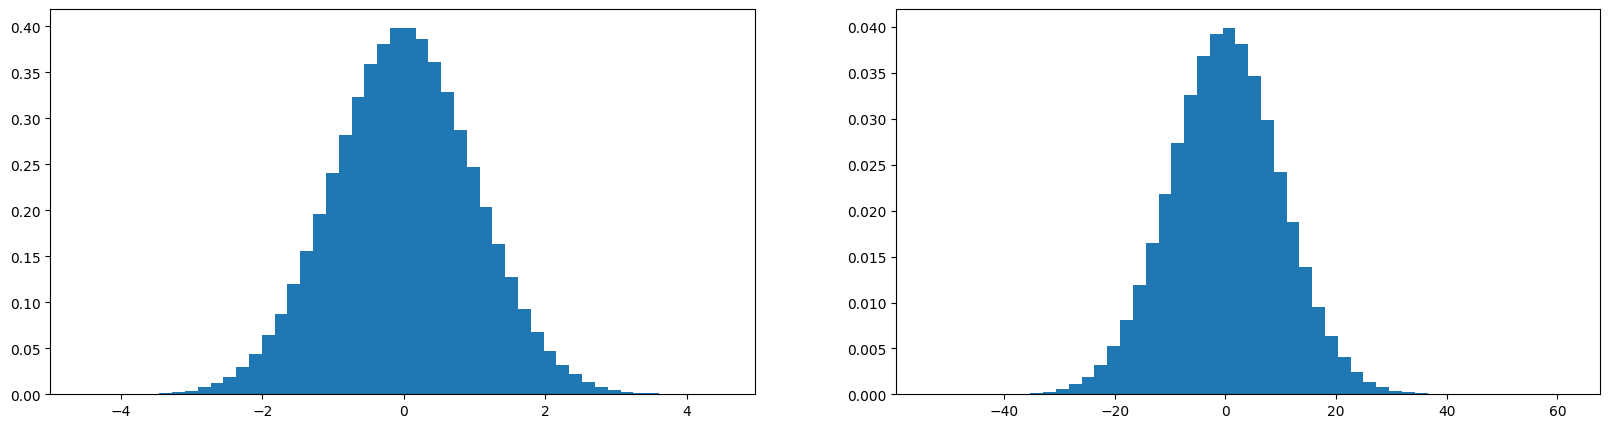

In [ ]:
x = torch.randn(1000, 100)
w = torch.randn(100, 500)
y = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(y.mean(), y.std()) # why is the std different than the two above?
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(0.0192) tensor(1.0086)
tensor(-0.0064) tensor(0.9917)
tensor(0.0122) tensor(3.1667)


(array([1.44301329e-05, 2.16451994e-05, 2.16451994e-05, 5.05054653e-05,
        1.08225997e-04, 1.29871196e-04, 2.45312260e-04, 3.60753324e-04,
        5.05054653e-04, 1.00289424e-03, 1.59452969e-03, 2.69843486e-03,
        4.31460975e-03, 6.89760355e-03, 1.03319752e-02, 1.52526505e-02,
        2.27346745e-02, 3.25471649e-02, 4.43870889e-02, 6.08951610e-02,
        7.97697749e-02, 9.90700777e-02, 1.15383343e-01, 1.30159799e-01,
        1.33053041e-01, 1.33421009e-01, 1.21559440e-01, 1.03983538e-01,
        8.68910455e-02, 6.86297123e-02, 5.16093705e-02, 3.67535486e-02,
        2.66163802e-02, 1.85427208e-02, 1.16234721e-02, 8.47770310e-03,
        5.07940680e-03, 3.31893058e-03, 1.96971315e-03, 1.29871196e-03,
        5.91635451e-04, 4.76194387e-04, 2.09236928e-04, 2.09236928e-04,
        9.37958641e-05, 3.60753324e-05, 3.60753324e-05, 1.44301329e-05,
        1.44301329e-05, 7.21506647e-06]),
 array([-17.10577965, -16.41278534, -15.71979103, -15.02679672,
        -14.33380241, -13.6408

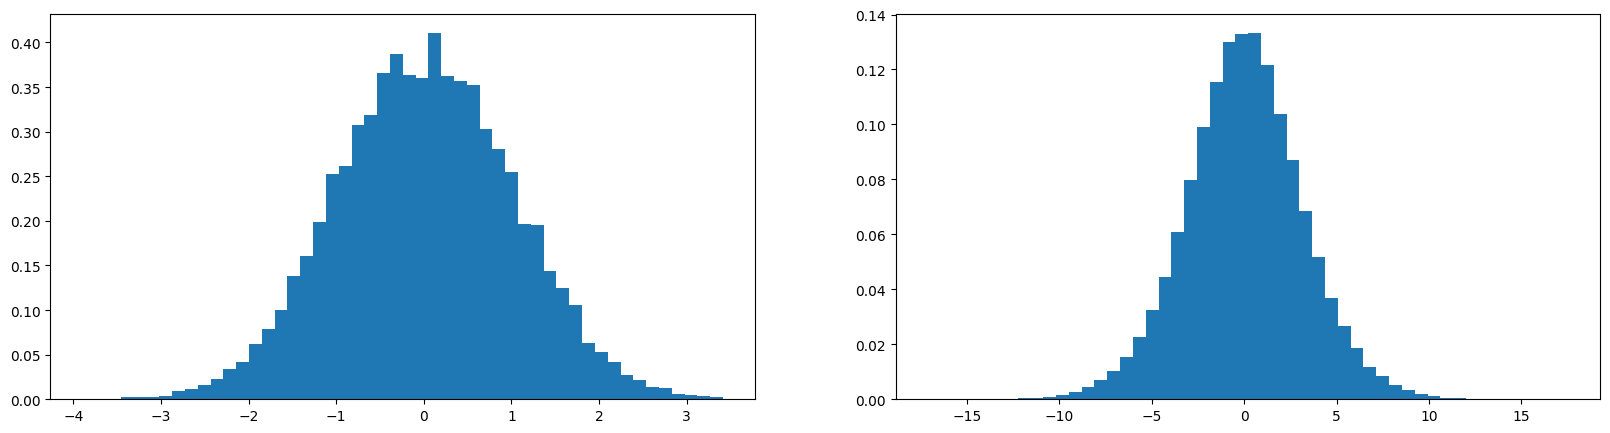

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

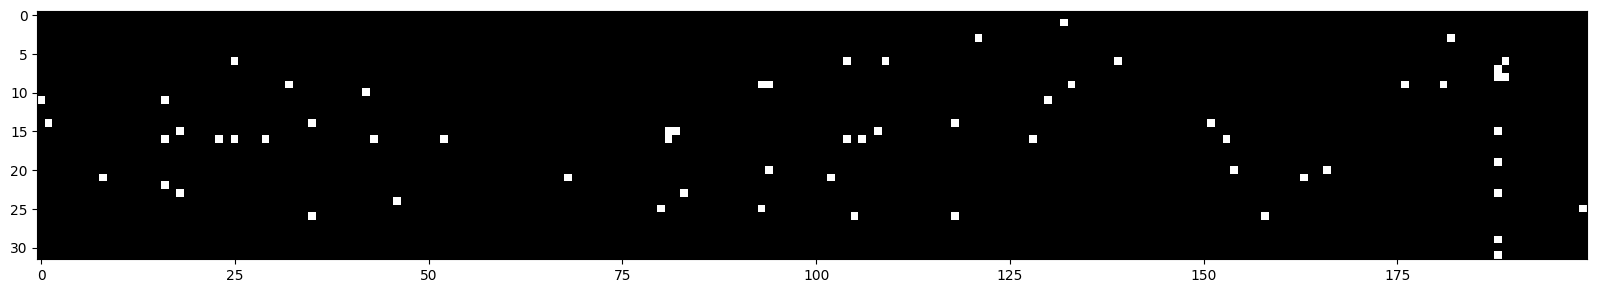

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

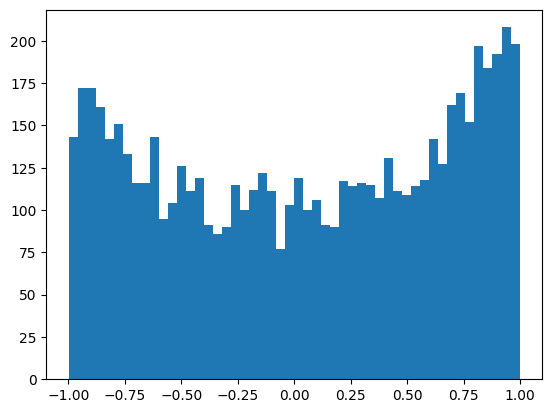

In [ ]:
plt.hist(h.view(-1).tolist(), 50)

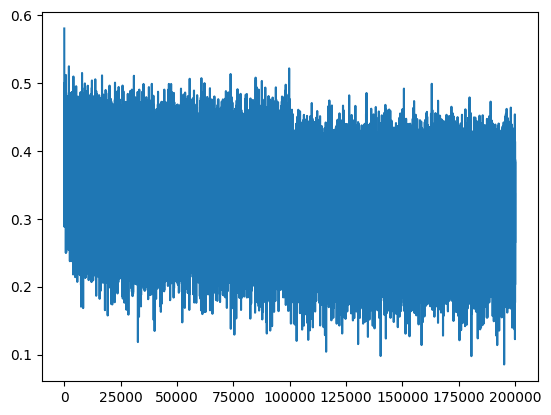

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    } [split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # layer normalization
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.035606861114502
dev 2.102713108062744
